In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split as tts
import scikitplot as skplt

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

np.random.seed(42)
random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


  Obtaining dependency information for pymorphy2 from https://files.pythonhosted.org/packages/07/57/b2ff2fae3376d4f3c697b9886b64a54b476e1a332c67eee9f88e7f1ae8c9/pymorphy2-0.9.1-py3-none-any.whl.metadata
  Obtaining dependency information for dawg-python>=0.7.1 from https://files.pythonhosted.org/packages/6a/84/ff1ce2071d4c650ec85745766c0047ccc3b5036f1d03559fd46bb38b5eeb/DAWG_Python-0.7.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pymorphy2-dicts-ru<3.0,>=2.4 from https://files.pythonhosted.org/packages/3a/79/bea0021eeb7eeefde22ef9e96badf174068a2dd20264b9a378f2be1cdd9e/pymorphy2_dicts_ru-2.4.417127.4579844-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 76.0 MB/s eta 0:00:00:00:0100:01
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# EDA

In [3]:
df = pd.read_csv("/kaggle/input/youtube/youtube_train.csv")
df

,id,Channel,Subtitles,PublishDate,Category,ViewCount
0,0,toplesofficial,('Я миллениал и я не занимаюсь сексом так част...,2017-12-31T01:35:44-08:00,Education,3019
1,1,postnauka,"(""сервитуты это одно из прямых наследие римско...",2014-09-04T08:24:47-07:00,Science & Technology,25
2,2,NaukaPRO,('[музыка] существуют сенсоры измеряющие магни...,2023-11-23T21:00:08-08:00,Science & Technology,7
3,3,postnauka,('в наше время только ленивые не говорит о том...,2014-06-23T03:49:31-07:00,Science & Technology,5
4,4,user-rb8ux1no6j,('дорогие друзья это честный рекламный ролик н...,2020-10-09T01:30:04-07:00,Education,10
...,...,...,...,...,...,...
5844,5844,postnauka,('в освоении ребенка нового слова ключевая про...,2015-11-05T00:43:12-08:00,Science & Technology,8
5845,5845,postnauka,('опуск языка и наука которая с этим связана к...,2013-06-04T03:11:25-07:00,Science & Technology,30
5846,5846,kurilka_gutenberga,('[музыка] что я хотела сегодня вам рассказать...,2019-01-26T01:00:06-08:00,Science & Technology,3
5847,5847,postnauka,('в истории как мы уже говорили один из популя...,2016-12-26T06:55:44-08:00,Science & Technology,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5849 entries, 0 to 5848
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           5849 non-null   int64 
 1   Channel      5849 non-null   object
 2   Subtitles    5849 non-null   object
 3   PublishDate  5849 non-null   object
 4   Category     5849 non-null   object
 5   ViewCount    5849 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 274.3+ KB


# lemmatize

In [5]:
m = MorphAnalyzer()
regex = re.compile("[А-я]+")
mystopwords = stopwords.words('russian')

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [12]:
from multiprocessing import Pool as PoolSklearn
#train
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, df['Subtitles']), total=len(df)))

df['text_lemmas'] = lemmas
df

100%|██████████| 5849/5849 [42:17<00:00,  2.31it/s]  


,id,Channel,Subtitles,PublishDate,Category,ViewCount,text_lemmas
0,0,toplesofficial,('Я миллениал и я не занимаюсь сексом так част...,2017-12-31T01:35:44-08:00,Education,3019,миллениал заниматься секс часто хотеться милле...
1,1,postnauka,"(""сервитуты это одно из прямых наследие римско...",2014-09-04T08:24:47-07:00,Science & Technology,25,сервитут прямой наследие римский право совреме...
2,2,NaukaPRO,('[музыка] существуют сенсоры измеряющие магни...,2023-11-23T21:00:08-08:00,Science & Technology,7,музыка существовать сенсор измерять магнитный ...
3,3,postnauka,('в наше время только ленивые не говорит о том...,2014-06-23T03:49:31-07:00,Science & Technology,5,время ленивый говорить интернет повлиять жизнь...
4,4,user-rb8ux1no6j,('дорогие друзья это честный рекламный ролик н...,2020-10-09T01:30:04-07:00,Education,10,дорогой друг честный рекламный ролик политика ...
...,...,...,...,...,...,...,...
5844,5844,postnauka,('в освоении ребенка нового слова ключевая про...,2015-11-05T00:43:12-08:00,Science & Technology,8,освоение ребёнок новый слово ключевой проблема...
5845,5845,postnauka,('опуск языка и наука которая с этим связана к...,2013-06-04T03:11:25-07:00,Science & Technology,30,опуск язык наука который связать корпусный лин...
5846,5846,kurilka_gutenberga,('[музыка] что я хотела сегодня вам рассказать...,2019-01-26T01:00:06-08:00,Science & Technology,3,музыка хотеть сегодня рассказать несколько пла...
5847,5847,postnauka,('в истории как мы уже говорили один из популя...,2016-12-26T06:55:44-08:00,Science & Technology,4,история говорить популярный формат аукцион гей...


In [6]:
df = pd.read_csv('/kaggle/input/df-lemmas-1/df_lemmas.csv')
df

,id,Channel,Subtitles,PublishDate,Category,ViewCount,text_lemmas,sym_len,word_len
0,0,toplesofficial,('Я миллениал и я не занимаюсь сексом так част...,2017-12-31T01:35:44-08:00,Education,3019,миллениал заниматься секс часто хотеться милле...,8387,1021
1,1,postnauka,"(""сервитуты это одно из прямых наследие римско...",2014-09-04T08:24:47-07:00,Science & Technology,25,сервитут прямой наследие римский право совреме...,6809,802
2,2,NaukaPRO,('[музыка] существуют сенсоры измеряющие магни...,2023-11-23T21:00:08-08:00,Science & Technology,7,музыка существовать сенсор измерять магнитный ...,9326,1042
3,3,postnauka,('в наше время только ленивые не говорит о том...,2014-06-23T03:49:31-07:00,Science & Technology,5,время ленивый говорить интернет повлиять жизнь...,8762,967
4,4,user-rb8ux1no6j,('дорогие друзья это честный рекламный ролик н...,2020-10-09T01:30:04-07:00,Education,10,дорогой друг честный рекламный ролик политика ...,1696,221
...,...,...,...,...,...,...,...,...,...
5759,5844,postnauka,('в освоении ребенка нового слова ключевая про...,2015-11-05T00:43:12-08:00,Science & Technology,8,освоение ребёнок новый слово ключевой проблема...,7426,872
5760,5845,postnauka,('опуск языка и наука которая с этим связана к...,2013-06-04T03:11:25-07:00,Science & Technology,30,опуск язык наука который связать корпусный лин...,7904,960
5761,5846,kurilka_gutenberga,('[музыка] что я хотела сегодня вам рассказать...,2019-01-26T01:00:06-08:00,Science & Technology,3,музыка хотеть сегодня рассказать несколько пла...,38298,4662
5762,5847,postnauka,('в истории как мы уже говорили один из популя...,2016-12-26T06:55:44-08:00,Science & Technology,4,история говорить популярный формат аукцион гей...,7662,921


In [7]:
arr_1 = []
for i in list(df['PublishDate']):
    arr_1.append(i.split('T')[0])

In [8]:
len(arr_1)

5764

In [9]:
pd.to_datetime(arr_1)

DatetimeIndex(['2017-12-31', '2014-09-04', '2023-11-23', '2014-06-23',
               '2020-10-09', '2015-02-01', '2021-08-20', '2017-04-13',
               '2017-12-01', '2019-12-30',
               ...
               '2017-06-30', '2020-05-18', '2015-06-02', '2015-01-28',
               '2019-12-20', '2015-11-05', '2013-06-04', '2019-01-26',
               '2016-12-26', '2015-09-22'],
              dtype='datetime64[ns]', length=5764, freq=None)

In [10]:
# convert the 'Date' column to datetime format
df['PublishDate']= pd.to_datetime(arr_1)
df

,id,Channel,Subtitles,PublishDate,Category,ViewCount,text_lemmas,sym_len,word_len
0,0,toplesofficial,('Я миллениал и я не занимаюсь сексом так част...,2017-12-31,Education,3019,миллениал заниматься секс часто хотеться милле...,8387,1021
1,1,postnauka,"(""сервитуты это одно из прямых наследие римско...",2014-09-04,Science & Technology,25,сервитут прямой наследие римский право совреме...,6809,802
2,2,NaukaPRO,('[музыка] существуют сенсоры измеряющие магни...,2023-11-23,Science & Technology,7,музыка существовать сенсор измерять магнитный ...,9326,1042
3,3,postnauka,('в наше время только ленивые не говорит о том...,2014-06-23,Science & Technology,5,время ленивый говорить интернет повлиять жизнь...,8762,967
4,4,user-rb8ux1no6j,('дорогие друзья это честный рекламный ролик н...,2020-10-09,Education,10,дорогой друг честный рекламный ролик политика ...,1696,221
...,...,...,...,...,...,...,...,...,...
5759,5844,postnauka,('в освоении ребенка нового слова ключевая про...,2015-11-05,Science & Technology,8,освоение ребёнок новый слово ключевой проблема...,7426,872
5760,5845,postnauka,('опуск языка и наука которая с этим связана к...,2013-06-04,Science & Technology,30,опуск язык наука который связать корпусный лин...,7904,960
5761,5846,kurilka_gutenberga,('[музыка] что я хотела сегодня вам рассказать...,2019-01-26,Science & Technology,3,музыка хотеть сегодня рассказать несколько пла...,38298,4662
5762,5847,postnauka,('в истории как мы уже говорили один из популя...,2016-12-26,Science & Technology,4,история говорить популярный формат аукцион гей...,7662,921


In [11]:
df['day_space'] = (pd.to_datetime('today').normalize() - df['PublishDate']).dt.days
df

,id,Channel,Subtitles,PublishDate,Category,ViewCount,text_lemmas,sym_len,word_len,day_space
0,0,toplesofficial,('Я миллениал и я не занимаюсь сексом так част...,2017-12-31,Education,3019,миллениал заниматься секс часто хотеться милле...,8387,1021,2281
1,1,postnauka,"(""сервитуты это одно из прямых наследие римско...",2014-09-04,Science & Technology,25,сервитут прямой наследие римский право совреме...,6809,802,3495
2,2,NaukaPRO,('[музыка] существуют сенсоры измеряющие магни...,2023-11-23,Science & Technology,7,музыка существовать сенсор измерять магнитный ...,9326,1042,128
3,3,postnauka,('в наше время только ленивые не говорит о том...,2014-06-23,Science & Technology,5,время ленивый говорить интернет повлиять жизнь...,8762,967,3568
4,4,user-rb8ux1no6j,('дорогие друзья это честный рекламный ролик н...,2020-10-09,Education,10,дорогой друг честный рекламный ролик политика ...,1696,221,1268
...,...,...,...,...,...,...,...,...,...,...
5759,5844,postnauka,('в освоении ребенка нового слова ключевая про...,2015-11-05,Science & Technology,8,освоение ребёнок новый слово ключевой проблема...,7426,872,3068
5760,5845,postnauka,('опуск языка и наука которая с этим связана к...,2013-06-04,Science & Technology,30,опуск язык наука который связать корпусный лин...,7904,960,3952
5761,5846,kurilka_gutenberga,('[музыка] что я хотела сегодня вам рассказать...,2019-01-26,Science & Technology,3,музыка хотеть сегодня рассказать несколько пла...,38298,4662,1890
5762,5847,postnauka,('в истории как мы уже говорили один из популя...,2016-12-26,Science & Technology,4,история говорить популярный формат аукцион гей...,7662,921,2651


# Визуализация

In [13]:
import warnings
warnings.filterwarnings('ignore')

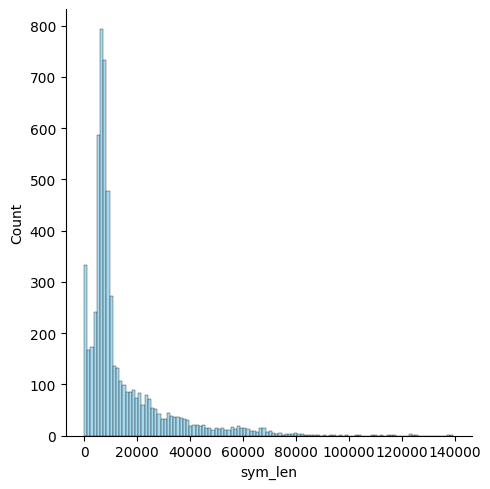

In [14]:
df['sym_len'] = df.text_lemmas.apply(len)
df['word_len'] = df.text_lemmas.apply(lambda x: len(x.split()))
df = df[df.sym_len > 0]
sns.displot(df["sym_len"] , color="skyblue", label="Symdol Length");

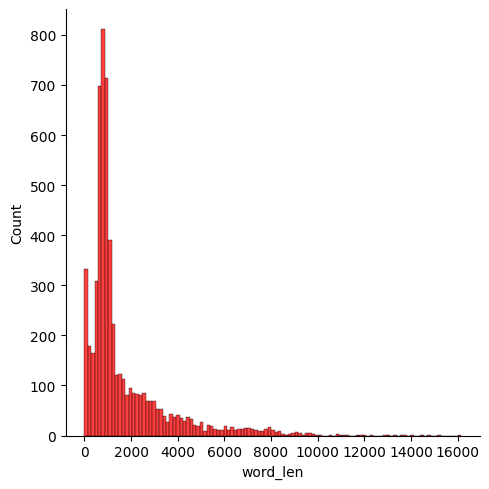

In [15]:
sns.displot(df['word_len'] , color="red", label="Word Length");

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5764 entries, 0 to 5763
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           5764 non-null   int64         
 1   Channel      5764 non-null   object        
 2   Subtitles    5764 non-null   object        
 3   PublishDate  5764 non-null   datetime64[ns]
 4   Category     5764 non-null   object        
 5   ViewCount    5764 non-null   int64         
 6   text_lemmas  5764 non-null   object        
 7   sym_len      5764 non-null   int64         
 8   word_len     5764 non-null   int64         
 9   day_space    5764 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 450.4+ KB


# Catboost

In [13]:
!pip install catboost

In [14]:
from catboost import CatBoostRegressor
from catboost import Pool

def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostRegressor(
        iterations=20000,
        learning_rate=0.05,
        loss_function='RMSE',
        use_best_model= True,
        task_type='GPU',
        #text_processing = text_processing
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=1000,
    )

In [16]:
X = df[['Subtitles','text_lemmas','Channel','Category','sym_len','word_len','day_space']]
y = df['ViewCount']
X_train, X_test, y_train, y_test = tts(X, y,random_state=42, train_size=0.85, shuffle=True)

In [17]:
train_pool = Pool(
    X_train, y_train,
    cat_features=['Channel','Category'],
    text_features=['Subtitles','text_lemmas'],
)


val_pool = Pool(
    X_test, y_test,
    cat_features=['Channel','Category'],
    text_features=['Subtitles','text_lemmas'],
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

cat_boost = fit_model(train_pool, val_pool)

Train dataset shape: (4899, 7)

0:	learn: 1164.7129604	test: 1119.0180336	best: 1119.0180336 (0)	total: 5.12s	remaining: 1d 4h 26m 32s
1000:	learn: 258.3813006	test: 376.8601403	best: 368.0530874 (303)	total: 21.9s	remaining: 6m 56s
2000:	learn: 210.6355007	test: 374.1946080	best: 368.0530874 (303)	total: 37.2s	remaining: 5m 34s
3000:	learn: 182.5071812	test: 371.9233932	best: 368.0530874 (303)	total: 50.5s	remaining: 4m 46s
4000:	learn: 160.0938437	test: 371.3804525	best: 368.0530874 (303)	total: 1m 4s	remaining: 4m 19s
5000:	learn: 146.4906290	test: 370.3073056	best: 368.0530874 (303)	total: 1m 19s	remaining: 3m 56s
6000:	learn: 137.0182038	test: 370.2898099	best: 368.0530874 (303)	total: 1m 31s	remaining: 3m 32s
7000:	learn: 128.9858696	test: 370.1588098	best: 368.0530874 (303)	total: 1m 44s	remaining: 3m 13s
8000:	learn: 121.2184854	test: 370.5661221	best: 368.0530874 (303)	total: 1m 57s	remaining: 2m 56s
9000:	learn: 113.4119152	test: 370.4576891	best: 368.0530874 (303)	total: 2m 

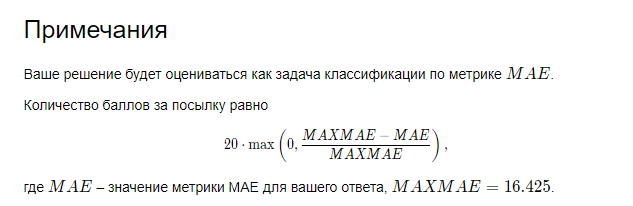

In [20]:
y_pred = cat_boost.predict(val_pool)
from sklearn import metrics
metrics.mean_squared_error(y_test, y_pred, squared=False)

368.0530523645206

# predict

In [21]:
test = pd.read_csv("/kaggle/input/youtube/youtube_test.csv")
test

,id,Channel,Subtitles,PublishDate,Category
0,5849,RedRoomLIMB/videos,('война война никогда не меняется римляне воев...,2019-10-15T11:02:01-07:00,People & Blogs
1,5850,NaukaPRO,('[музыка] ну одним из ярких феноменов северо-...,2018-11-24T23:38:38-08:00,Science & Technology
2,5851,UtopiaShow,('После прошлого выпуска\nхочется чего-то весе...,2019-09-24T04:26:19-07:00,Entertainment
3,5852,Arzamaschannel,('добрый день мы с вами сегодня тоже проводим ...,2020-02-15T09:35:48-08:00,Education
4,5853,postnauka,"('Время, о котором мы будем\nговорить, получил...",2019-03-11T03:39:22-07:00,Science & Technology
...,...,...,...,...,...
1995,7844,postnauka,('то что днк представляет собой длинную полиме...,2014-11-17T04:21:25-08:00,Science & Technology
1996,7845,postnauka,('внутренние волны это такое явление в океане ...,2014-03-20T03:37:38-07:00,Science & Technology
1997,7846,AntropogenezRu,('[аплодисменты] [музыка] пожалуй почти никто ...,2019-08-29T09:45:00-07:00,Science & Technology
1998,7847,postnauka,('Что такое мета-вселенная Чем метаверс отлича...,2022-11-21T02:25:37-08:00,Science & Technology


In [22]:
arr_1 = []
for i in list(test['PublishDate']):
    arr_1.append(i.split('T')[0])
test['PublishDate']= pd.to_datetime(arr_1)
test['day_space'] = (pd.to_datetime('today').normalize() - test['PublishDate']).dt.days
test

,id,Channel,Subtitles,PublishDate,Category,day_space
0,5849,RedRoomLIMB/videos,('война война никогда не меняется римляне воев...,2019-10-15,People & Blogs,1628
1,5850,NaukaPRO,('[музыка] ну одним из ярких феноменов северо-...,2018-11-24,Science & Technology,1953
2,5851,UtopiaShow,('После прошлого выпуска\nхочется чего-то весе...,2019-09-24,Entertainment,1649
3,5852,Arzamaschannel,('добрый день мы с вами сегодня тоже проводим ...,2020-02-15,Education,1505
4,5853,postnauka,"('Время, о котором мы будем\nговорить, получил...",2019-03-11,Science & Technology,1846
...,...,...,...,...,...,...
1995,7844,postnauka,('то что днк представляет собой длинную полиме...,2014-11-17,Science & Technology,3421
1996,7845,postnauka,('внутренние волны это такое явление в океане ...,2014-03-20,Science & Technology,3663
1997,7846,AntropogenezRu,('[аплодисменты] [музыка] пожалуй почти никто ...,2019-08-29,Science & Technology,1675
1998,7847,postnauka,('Что такое мета-вселенная Чем метаверс отлича...,2022-11-21,Science & Technology,495


In [25]:
from multiprocessing import Pool as PoolSklearn
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, test['Subtitles']), total=len(test)))

test['text_lemmas'] = lemmas
test

100%|██████████| 2000/2000 [13:49<00:00,  2.41it/s]


,id,Channel,Subtitles,PublishDate,Category,day_space,text_lemmas
0,5849,RedRoomLIMB/videos,('война война никогда не меняется римляне воев...,2019-10-15,People & Blogs,1628,война война меняться римлянин воевать богатств...
1,5850,NaukaPRO,('[музыка] ну одним из ярких феноменов северо-...,2018-11-24,Science & Technology,1953,музыка яркий феномен северо западный кавказ яв...
2,5851,UtopiaShow,('После прошлого выпуска\nхочется чего-то весе...,2019-09-24,Entertainment,1649,прошлое выпуск хотеться весёлый весь привет ко...
3,5852,Arzamaschannel,('добрый день мы с вами сегодня тоже проводим ...,2020-02-15,Education,1505,добрый день сегодня проводить эксперимент напи...
4,5853,postnauka,"('Время, о котором мы будем\nговорить, получил...",2019-03-11,Science & Technology,1846,время который говорить получить обозначение зо...
...,...,...,...,...,...,...,...
1995,7844,postnauka,('то что днк представляет собой длинную полиме...,2014-11-17,Science & Technology,3421,представлять длинный полимерный цепочка означа...
1996,7845,postnauka,('внутренние волны это такое явление в океане ...,2014-03-20,Science & Technology,3663,внутренний волна явление океан который вызыват...
1997,7846,AntropogenezRu,('[аплодисменты] [музыка] пожалуй почти никто ...,2019-08-29,Science & Technology,1675,аплодисменты музыка пожалуй никто избежать зар...
1998,7847,postnauka,('Что такое мета-вселенная Чем метаверс отлича...,2022-11-21,Science & Technology,495,мета вселенная метаверс отличаться игра социал...


In [26]:
test['sym_len'] = test.text_lemmas.apply(len)
test['word_len'] = test.text_lemmas.apply(lambda x: len(x.split()))

In [27]:
test_pool = Pool(
    test[['Subtitles','text_lemmas','Channel','Category','sym_len','word_len','day_space']],
    cat_features=['Channel','Category'],
    text_features=['Subtitles','text_lemmas'],
)

y_pred = cat_boost.predict(test_pool)


In [30]:
y_pred

array([8.28127234e+02, 2.98644914e+01, 3.88076483e+03, ...,
       8.41461812e+01, 1.85431622e+01, 3.15497740e+00])

In [29]:
np.round(y_pred)

array([8.280e+02, 3.000e+01, 3.881e+03, ..., 8.400e+01, 1.900e+01,
       3.000e+00])

In [33]:
submission = pd.read_csv("/kaggle/input/youtube/youtube_sample_submission.csv")
submission['ViewCount'] = y_pred
submission

,id,ViewCount
0,5849,828.127234
1,5850,29.864491
2,5851,3880.764833
3,5852,73.740121
4,5853,61.539430
...,...,...
1995,7844,9.782320
1996,7845,16.059815
1997,7846,84.146181
1998,7847,18.543162


In [34]:
submission.to_csv("catboost_NLP.csv", index = False)